In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Normalization, Dense, InputLayer,MaxPool2D,Conv2D,Flatten,BatchNormalization,Input,Layer
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError,BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from google.colab import files,drive
from tensorflow.keras.models import Model

Data Preparation

Data Loading

In [ ]:
dataset,dataset_info = tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete7RHA6J/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmpokkxouxptfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [ ]:
for data in dataset[0].take(8):
    print(data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(133, 127, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [ ]:
def splits(dataset,TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))

    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

    test_dataset = val_test_dataset.skip((int(VAL_RATIO*DATASET_SIZE)))
    return train_dataset,val_dataset,test_dataset

In [ ]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.1
VAL_RATIO = 0.1

train_dataset,val_dataset,test_dataset = splits(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)

print(list(train_dataset.take(1).as_numpy_iterator()),list(val_dataset.take(1).as_numpy_iterator()),
      list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

Dataset Visualization

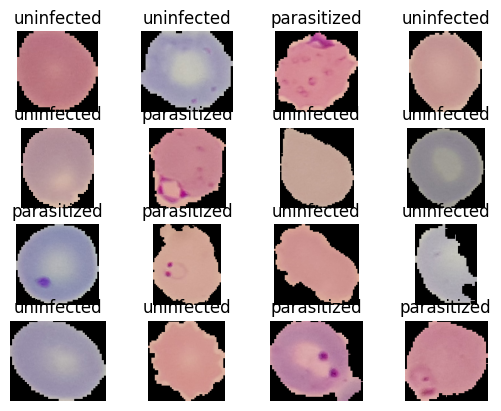

In [ ]:
for i,(image,label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(dataset_info.features['label'].int2str(label))

In [ ]:
dataset_info.features['label'].int2str(1)

'uninfected'

Data Loading

In [ ]:
IM_SIZE = 224
def resizing(image,label):
    return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0,label

In [ ]:
# Apply resizing to datasets
train_dataset = train_dataset.map(resizing).shuffle(buffer_size=8).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(resizing).shuffle(buffer_size=8).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(resizing).shuffle(buffer_size=8).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
for image,label in train_dataset.take(1):
    print(image,label)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

Model Building

In [ ]:
model = tf.keras.Sequential([
                                InputLayer(input_shape=(IM_SIZE,IM_SIZE,3)),
                                Conv2D(filters=6,kernel_size=3,strides=1,padding='valid',activation='sigmoid'),
                                BatchNormalization(),
                                MaxPool2D(pool_size=2,strides=2),

                                Conv2D(filters=16,kernel_size=3,strides=1,padding='valid',activation='sigmoid'),
                                BatchNormalization(),
                                MaxPool2D(pool_size=2,strides=2),
                                Flatten(),

                                Dense(1000,activation='relu'),
                                BatchNormalization(),

                                Dense(100,activation='relu'),
                                BatchNormalization(),

                                Dense(1,activation='sigmoid'),


])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_2 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_3 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

Functional API

In [ ]:
func_inp = Input(shape=(IM_SIZE,IM_SIZE,3),name='Image input')
x = Conv2D(filters=6,kernel_size=3,strides=1,padding='valid',activation='sigmoid')(func_inp)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2,strides=2)(x)

x = Conv2D(filters=16,kernel_size=3,strides=1,padding='valid',activation='sigmoid')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2,strides=2)(x)

feature_extractor_model = Model(func_inp,output,name='Feature_Extractor')

feature_extractor_model.summary()


Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_6 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_7 (Bat  (None, 109, 109, 16)

In [ ]:
func_inp = Input(shape=(IM_SIZE,IM_SIZE,3),name='Image input')
x = feature_extractor_model(func_inp)

x = Flatten()(x)

x = Dense(1000,activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(100,activation='relu')(x)
x = BatchNormalization()(x)

func_out = Dense(1,activation='sigmoid')(x)

model_func = Model(func_inp,func_out,name='Feature_Extractor')

model_func.summary()


Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 1000)              46657000  
                                                                 
 batch_normalization_8 (Bat  (None, 1000)              4000      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 100)         

Model Subclassing

In [ ]:
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
        super(FeatureExtractor, self).__init__()
        self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*strides)

        self.conv_2 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    def call(self, x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)

        return x

# Creating an instance of the FeatureExtractor class
feature_sub_classed = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)


Model Training

In [ ]:
model_func.compile(optimizer=Adam(learning_rate=0.01),loss=BinaryCrossentropy(),metrics=['accuracy'])

In [ ]:
history = model_func.fit(train_dataset,validation_data=val_dataset,epochs=20)

Epoch 1/20
  5/689 [..............................] - ETA: 24:04 - loss: 1.1865 - accuracy: 0.5688

KeyboardInterrupt: 

Checking accuracy

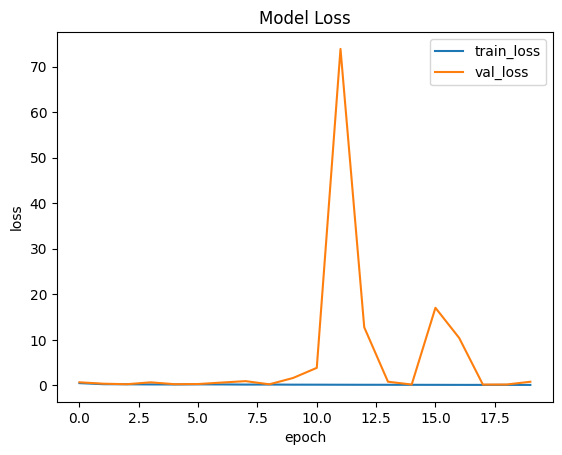

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

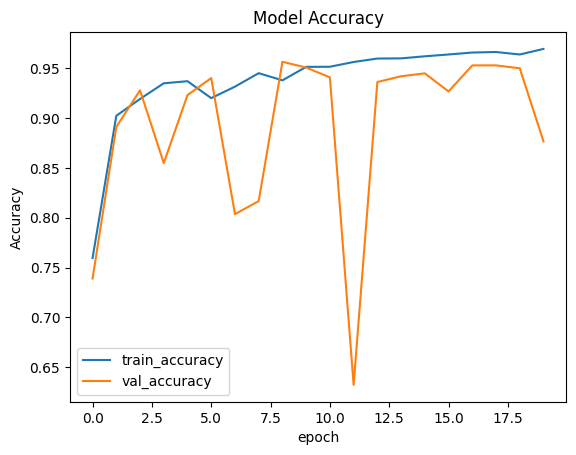

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

In [ ]:
model.evaluate(test_dataset)

87/87 [==============================] - 15s 33ms/step - loss: 0.7096 - accuracy: 0.8672


[0.7096329927444458, 0.8672469854354858]

In [ ]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 11s 11s/step


0.99998856

In [ ]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 12s 12s/step


'U'

1/1 [==============================] - 0s 30ms/step


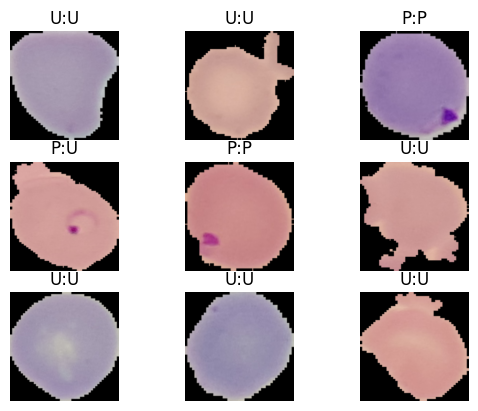

In [ ]:
for i,(image,label) in enumerate(test_dataset.take(9)):

    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0]))+ ':' + str(parasite_or_not(model.predict(image)[0][0])))

    plt.axis('off')

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
%cd /content/drive/My Drive/Colab Notebooks/


/content/drive/My Drive/Colab Notebooks


In [16]:
!git branch -m master main

error: refname refs/heads/master not found
fatal: Branch rename failed
